In [1]:
# Run when using Google Colab, not a default package so I have to install every time
!pip install mrexo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 MB 9.4 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mrexo.predict_nd import Mdwarf_InferPlMass_FromPlRadiusStMass, Mdwarf_InferPlMass_FromPlRadius
import scipy.integrate as spi
from scipy.optimize import fsolve
import copy

/usr/local/lib/python3.10/dist-packages/mrexo/datasets/MdwarfRuns


## Constants:

In [3]:
n_cmax = 5 # max number of clusters
n_pmax = 7 # max number of planets per cluster
"""
both values can be changed to produce desired distributions
"""

p_l, p_h = 0, 2 # high and low limits for log-scale periods (to draw from uniform distribution)
k = 1 # proportional coefficient for Kepler's third law, a^3 = kp^2
f_swpa_med = 0.88
m = 0.9
lambda_c = 1
lambda_p = 1.6 # expected number of planets around a star
delta_c = 10
alpha_p = 0
alpha_r1 = -1.4
alpha_r2 = -5.2
alpha_e1 = 0.25
sigma_r = 0.3
sigma_p = 0.25
sigma_e1 = 0.25
r_p_break = 3 # in Earth radii units
r_p_min = 0.5 # Earth radii
r_p_max = 10 # Earth radii
p_min = 3 # days
p_max = 300 # days

## Functions:

In [4]:
def ztp(l, n):
    """
    zero truncated poisson function

    Parameters
    ----------
    l : int
        Mean of the distribution, lambda.
    n : int
        Number of times the distribution is sampled.

    Returns
    -------
    int if sampled once (n=1), an array otherwise
    """
    if n == 1:
        x = 0
        while x == 0:
            x = np.random.poisson(l)
        return x
    else:
        x = np.random.poisson(l, n)
        for i in range(n):
            while x[i] == 0:
                x[i] = np.random.poisson(l)
        return x

def radii():
    """
    Establishes the broken power law distribution, and draws a radius from it using a rudimentary integrating function.
    It divides the possible r_p values up into the number of increments (int), and calculates its associated integral value.
    It then draws a random value from (0,1) and outputs the r_p value with the closest integral value.

    Returns
    -------
    float:
        The radius of the planet
    """
    inc = 600
    x = np.linspace(r_p_min, r_p_max, inc)
    y = np.zeros((inc, 2))
    rpc1 = lambda x: x ** alpha_r1 # broken power functions
    rpc2 = lambda x: r_p_break ** (alpha_r1 - alpha_r2) * x ** alpha_r2 # constant used to stitch together the two regimes
    for i in range(len(x)):
        if x[i] <= r_p_break:
            y[i] = [x[i], spi.quad(rpc1, r_p_min, x[i])[0]]
        else:
            y[i] = [x[i], spi.quad(rpc1, r_p_min, r_p_break)[0] + spi.quad(rpc2, r_p_break, x[i])[0]]
    normalization = spi.quad(rpc1, r_p_min, r_p_break)[0] + spi.quad(rpc2, r_p_break, r_p_max)[0] # sum of entire area under curve
    i = np.random.uniform(0, 1)
    id = (np.abs(y[:,1]/normalization - i)).argmin() # index of closest point
    return y[id, 0]

def period_scale(): # period scale factor
    """
    similar to radii() function, except using a single power law.

    Returns
    -------
    float:
        The period scale of the planet
    """
    inc = 600
    x = np.linspace(p_min, p_max, inc)
    y = np.zeros((inc, 2))
    pc = lambda x: x ** alpha_p # power law
    for i in range(len(x)):
        y[i] = [x[i], spi.quad(pc, p_min, x[i])[0]]
    normalization = spi.quad(pc, p_min, p_max)[0] # sum of entire area under curve
    i = np.random.uniform(0, 1)
    id = (np.abs(y[:,1]/normalization - i)).argmin() # index of closest point
    return y[id, 0]

def unscaled_stab_condition(n_p: int, p_masses, m_star: float):
    """
    Step 4(d) of the New Procedure in section 2.3.4., drawing unscaled periods of multi-planet clusters.
    Generates a list of periods and tests them using the equations of stability criteria.
    If any of the stab conditions are not met, the boolean stability switches to False, and the process restarts.

    Parameters
    ----------
    n_p : int
        Number of planets in cluster
    p_masses : array(float)
        Array of masses of planets in cluster
    m_star : float
        Mass of star in cluster

    Returns
    -------
    array of periods if stability is met,
    [0] otherwise to indicate max number of attempts has been reached, to be discarded
    """
    s = 0
    while s < 100:
        stability = True
        periods = np.random.lognormal(0, n_p*sigma_p, int(n_p)) # drawing unscaled periods
        periods = np.sort(periods)
        for i in range(len(periods)-1):
            # Eq (9):
            r_h = 0.5 * (periods[i]+periods[i+1]) * ((p_masses[i] + p_masses[i+1])/(3*333000*m_star)) ** (1/3)
            # Eq (8), assuming eccentricity = 0 since it hasn't been computed yet
            stab_cond = (periods[i+1] - periods[i])/r_h
            if stab_cond <= 8: # stability criterion
                stability = False
                s += 1
                break
            # Eq (23):
            mu_1 = p_masses[i] / (333000*m_star) #planet star mass ratio
            mu_2 = p_masses[i+1] / (333000*m_star)
            # Eq (22):
            alpha_crit = 1 - 1.46 * (mu_1 + mu_2) ** (2 / 7)
            alpha = (periods[i]/periods[i+1]) ** (2/3) # semimajor axis ratio (from period conversion)
            if alpha > alpha_crit: # against mean motion resonance overlap
                stability = False
                s += 1
                break
        if stability:
            break
    if s == 100:
        return [0]
    # print(s): use to check how many iterations the stability condition has been tested
    return periods

def scale_stab_condition(n_p: int, previous_planets, p_masses, unscaled_per, m_star):
    """
    Very similar to the previous unscaled_stab_condition()
    Step 4(e) of the New Procedure in section 2.3.4., scaling the periods of each cluster, just with more stability conditions.

    Parameters
    ----------
    n_p : int
        Number of planets in cluster
    previous_planets : 2D array([float, float])
        Array of information of all previous, scaled planets.
        Each entry represents one planet, in the form of [period, mass]
    p_masses : array(float)
        Array of masses of planets in cluster
    unscaled_per : array(float)
        Array of unscaled periods of planets in cluster
    m_star : float
        Mass of star in cluster

    Returns
    -------
    float: multiplier for the periods if stability is met,
    0 otherwise to indicate max number of attempts has been reached, to be discarded
    """
    # previous_planets will be a 2D array, where each entry is for one planet, in the form of [period, mass], from all previous clusters
    # p_masses and unscaled_per are values for the current cluster

    # Step 4(e) scaling periods (days)
    test_scaled_periods = []
    q = 0
    while q < 100:
        p_c = period_scale()
        scaled_periods = p_c * unscaled_per

        # The program sometimes gets stuck here, as it can't choose a good period_scale given the unscaled periods
        # After 100 tries, discards cluster
        count = 0
        stuck = False
        while scaled_periods[0] < p_min or scaled_periods[-1] > p_max:
            count += 1
            if count > 100:
                stuck = True
                break
            p_c = period_scale()
            scaled_periods = p_c * unscaled_per
        if stuck == True:
            break
        test_scaled_periods = copy.deepcopy(previous_planets)
        for i in range(len(scaled_periods)):
            test_scaled_periods.append([scaled_periods[i], p_masses[i]])
        test_scaled_periods.sort(key=lambda x: x[0])
        stability = True
        for i in range(len(test_scaled_periods)-1):
            r_h = 0.5 * (test_scaled_periods[i][0]+test_scaled_periods[i+1][0]) * ((test_scaled_periods[i][1] + test_scaled_periods[i+1][1])/(3*333000*m_star)) ** (1/3)
            stab_cond = (test_scaled_periods[i+1][0] - test_scaled_periods[i][0])/r_h
            if stab_cond <= 8: # stability criterion
                stability = False
                q += 1
                break
            mu_1 = test_scaled_periods[i][1] / (333000*m_star) #planet star mass ratio
            mu_2 = test_scaled_periods[i+1][1] / (333000*m_star)
            alpha_crit = 1 - 1.46 * (mu_1 + mu_2) ** (2 / 7)
            alpha = (test_scaled_periods[i][0]/test_scaled_periods[i+1][0]) ** (2/3) # semimajor axis ratio (from period conversion)
            if alpha > alpha_crit: # against mean motion resonance overlap
                stability = False
                q += 1
                break
        if stability:
            break
    if stuck == True:
        return 0
    if q == 100:
        return 0
    #print(q): use to check how many iterations the stability condition has been tested
    return p_c

In [5]:
def computeGamma(mp, ms, period):
    """
    Equation (12) Under 2.3.1. Calculates the capital Gamma of a given planet.

    Parameters
    ----------
    mp : float
        Mass of planet in Earth masses
    ms : float
        Mass of star in Sun masses
    period : float
        Period of planet

    Returns
    -------
    float: Gamma_k of the planet
    """
    return mp / (ms * 333000) * np.sqrt(k * period ** (2/3))

def e1func(x, *inputs):
    """
    Equation (18) Under 2.3.1. Simply returns the equation to be solved for e_1.

    Parameters
    ----------
    x : float
        e_1 = e_crit

    Returns
    -------
    equation to be solved
    """
    alpha, gamma = inputs
    return alpha*(x + 1) + (gamma * x) / (np.sqrt(alpha*(1-x ** 2) + gamma ** 2 * x ** 2)) - 1

def calculate_AMD(planets, m_s): #planets is a list, with
    """
    Calculates AMD using Equation (31) Under 2.3.1.
    Does this by calculating the two collision and mmr stability values for each planet pair.

    Parameters
    ----------
    planets : 2D array([float, float])
        Array of information of all previous, scaled planets.
        Each entry represents one planet, in the form of [period, mass]
    m_s : float
        Mass of star in cluster

    Returns
    -------
    float: total AMD of the cluster
    """
    AMD_crit_array = np.zeros(len(planets))

    AMD_crit_array[0] = computeGamma(planets[0][1], m_s, planets[0][0])

    for i in range(len(planets)-1):
        # compute the two criteria for AMD, and insert the minimum one into the AMD_crit_array
        gamma = planets[i][1] / planets[i + 1][1]
        alpha = (planets[i][0] / planets[i + 1][0]) ** (2/3)

        inputs = (alpha, gamma)

        e_1 = fsolve(e1func, 1, args=inputs)[0]
        e_2 = 1 - alpha - alpha * e_1

        #critical relative AMD for collision
        C_coll = gamma * np.sqrt(alpha) * (1-np.sqrt(1-e_1**2)) + (1-np.sqrt(1-e_2**2))

        #critical relative AMD for MMR
        r = 0.80199
        epsilon = (planets[i][1] + planets[i + 1][1]) / (m_s * 330000)
        g = (81 * (1 - alpha) ** 5) / (2**9 * r * epsilon) - (32 * r * epsilon) / (9 * (1 - alpha) ** 2)

        C_MMR = (g ** 2 * gamma * np.sqrt(alpha)) / (2 + 2 * gamma * np.sqrt(alpha))

        AMD_crit_array[i+1] = computeGamma(planets[i + 1][1], m_s, planets[i + 1][0]) * min(C_coll, C_MMR)

    AMD_crit = min(AMD_crit_array)

    return AMD_crit

def random_trisect():
    """
    Little mathematical function, outputs three random numbers that sum to 1.
    This is bad notation, but the x, y, z values here actually correspond to x^2, y^2, and z^2 in the paper (hence the sqrt later on).

    Returns
    -------
    array(float): three floats that sum to 1
    """

    a = np.random.uniform(0, 1)
    b = np.random.uniform(0, 1)
    if a < b:
        x = a
        y = b - a
        z = 1 - b
        return [x, y, z]
    else:
        x = b
        y = a - b
        z = 1 - a
        return [x, y, z]

## Code to generate a single system:

In [6]:
# How the data is structured:
# Frame 0 contains stellar information:
# On first frame in first row:
# [0]: stellar radius (solar rad) INPUT
# [1]: stellar mass (solar mass) INPUT
# [2]: total AMD
# [3]: number of clusters
# [4]: number of planets total
#
# On each subsequent frame, each representing a cluster:
# the last row contains:
# [0] number of planets in this cluster
# [1] period scale factor
#
# Each previous row represents one planet, with each column:
# [0] radius
# [1] mass
# [2] unscaled period
# [3] scaled period
# [4] AMD of planet
# [5] AMD in x
# [6] AMD in y
# [7] AMD in z
# [8] eccentricity
# [9] omega (argument of pericenter) (in radians)
# [10] mutial inclination rel. to system invar. plane
# [11] angle of ascending node
# [12] mean anomaly
# [13] inclination

In [10]:
# Step 2: compute whether the system contains planets using its Gaia Intrinsic Color
c = 0
while c < 0.5 or c > 1.7:
    c = np.random.rayleigh(0.81) #not sure if this is allowed
f_swpa = max(0, min(m*(c-0.81)+f_swpa_med, 1))

if np.random.uniform(0, 1) > f_swpa:
    print('No Planets')
    clusters = 0
    planets_array = [0]
else:
    # Step 3: generate number of clusters in the system, no more than N_c,max
    clusters = ztp(lambda_c, 1)
    while clusters > n_cmax:
        clusters = ztp(lambda_c, 1)

    planets_array = ztp(lambda_p, clusters)
    if clusters == 1:
        # because we want planets_array to be an array, if the output is a single integer, it gets put into an array of length 1
        planets_array = [planets_array]
    for i in range(len(planets_array)):
        # Step 4(a), drawing number of planets in each cluster, no more than N_p,max
        if planets_array[i] > n_pmax:
            planets_array[i] = ztp(lambda_p, 1)

print(clusters)
print(planets_array)

3
[2 3 1]


In [11]:
# generates the space needed for the data
# 1 frame for each cluster + 1 for first frame of stellar information
# rows as determined by the most number of planets in each cluster + 1 for keeping track of number of planets in each cluster
# 13 columns for data of each planet
data = np.zeros((clusters+1, np.max(planets_array)+1, 14))

data[0, 0, 0] = 1
data[0, 0, 1] = 1
data[0, 0, 2] = 3 #$to be calculated$
data[0, 0, 3] = clusters
data[0, 0, 4] = np.sum(planets_array)

for i in range(clusters):
    data[i+1,-1,0] = planets_array[i]

for i in range(clusters):
    good_cluster = False
    # The while loop exists to account for changes in data if a cluster is discarded, since cluster = cluster - 1
    # The break on the next line checks if we've completed the last cluster, and if so, break out of for loop
    if i + 1 == len(data):
        break
    while not good_cluster:
        if i + 1 == len(data):
            break
        i += 1 # This skips the first frame

        #Step 4(b)
        r_p_c = radii()
        while r_p_c < 0.5662: # The mass calculation function from mrexo has radii limits between 0.5661 and 14.421
            r_p_c = radii()
        if data[i, -1, 0] == 1:
            data[i, 0, 0] = r_p_c
        else:
            for j in range(int(data[i, -1, 0])):
                data[i, j, 0] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))
                while data[i, j, 0] < max(r_p_min, 0.5662) or data[i, j, 0] > min(r_p_max, 14.42): # These limits come from mrexo mass fitting bounds
                    data[i, j, 0] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))

        #Step 4(c)
        for j in range(int(data[i, -1, 0])):
            if data[0, 0, 1] < 0.072 or data[0, 0, 1] > 0.726: # if out of bounds for 3D fitting
                data[i, j, 1] = Mdwarf_InferPlMass_FromPlRadius(pl_rade = data[i, j, 0])[0]
            else:
                data[i, j, 1] = Mdwarf_InferPlMass_FromPlRadiusStMass(pl_rade=data[i, j, 0], st_mass=data[0, 0, 1])[0][0]

        # Step 4(d)
        if data[i, -1, 0] == 1:
            data[i, 0, 2] = 1 #unscaled period
            periods = np.array([1])
            masses = [data[i, 0, 1]]
        else:
            masses = data[i, 0:int(data[i, -1, 0]), 1:2]
            masses = np.concatenate(masses, axis=0)
            periods = unscaled_stab_condition(data[i, -1, 0], masses, data[0, 0, 1])
            if len(periods) == 1 and periods[0] == 0:
                # Stability condition not met, discard cluster
                data[0, 0, 3] -= 1
                data[0, 0, 4] -= data[i, -1, 0]
                data = np.delete(data, i, 0)
                i -= 1
                continue
            else:
                for j in range(len(periods)):
                    data[i, j, 2] = periods[j]

        # Step 4(e)
        prev_planets_info = []
        for j in range(i):
            for k in range(int(data[j, -1, 0])):
                prev_planets_info.append([data[j, k, 3], data[j, k, 1]])
        scale_factor = scale_stab_condition(data[i, -1, 0], prev_planets_info, masses, periods, data[0, 0, 1])
        if scale_factor == 0:
            # Stability condition not met, discard cluster
            data[0, 0, 3] -= 1
            data[0, 0, 4] -= data[i, -1, 0]
            data = np.delete(data, i, 0)
            i -= 1
            continue
        else:
            data[i, -1, 1] = scale_factor
            for j in range(int(data[i, -1, 0])):
                data[i, j, 3] = data[i, j, 2] * scale_factor

        good_cluster = True # This boolean should be flipped to True when everything is good with a cluster and is not discarded, so i increments properly

# Step 5
if data[0, 0, 4] == 1:
    data[1, 0, 8] = np.random.rayleigh(sigma_e1) #eccentricity
    data[1, 0, 9] = np.random.uniform(0, 2*np.pi) #pericenter
else:
    prev_planets_info = []
    for i in range(len(data)):
        if i == 0:
            continue
        for j in range(int(data[i, -1, 0])):
            prev_planets_info.append([data[i, j, 3], data[i, j, 1]])
    prev_planets_info.sort(key=lambda x: x[0])

    AMD_tot = calculate_AMD(prev_planets_info, data[0, 0, 1])
    data[0, 0, 2] = AMD_tot

    # Step 6: calculate the total mass of all planets combined
    total_planet_mass = 0
    for i in range(len(data)):
        if i == 0:
            continue
        for j in range(int(data[i, -1, 0])):
            total_planet_mass += data[i, j, 1]

    # Step 7: distribute AMD
    for i in range(len(data)):
        if i == 0:
            continue
        for j in range(int(data[i, -1, 0])):
            data[i, j, 4] = data[0, 0, 2] * data[i, j, 1] / total_planet_mass

    # Step 8
    for i in range(len(data)):
        if i == 0:
            continue
        for j in range(int(data[i, -1, 0])):
            Gamma = computeGamma(data[i, j, 1], data[0, 0, 1], data[i, j, 3])
            total_sum = (data[i, j, 4] / Gamma) * (2 - data[i, j, 4] / Gamma)
            trisect = random_trisect()
            trisect = [x * total_sum for x in trisect]
            data[i, j, 5] = np.sqrt(trisect[0])
            data[i, j, 6] = np.sqrt(trisect[1])
            data[i, j, 7] = np.sqrt(trisect[2])
            data[i, j, 8] = np.sqrt(trisect[0] + trisect[1])
            data[i, j, 9] = np.arctan(np.sqrt(trisect[0] / trisect[1]))
            data[i, j, 10] = np.arcsin(np.sqrt(trisect[2]))

# Step 9
for i in range(len(data)):
    if i == 0:
        continue
    for j in range(int(data[i, -1, 0])):
        data[i, j, 11] = np.random.uniform(0, 2*np.pi)
        data[i, j, 12] = np.random.uniform(0, 2*np.pi)

print(data)

[[[1.00000000e+00 1.00000000e+00 1.02143098e-06 3.00000000e+00
   6.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.22153119e+00 6.56104734e+00 7.51870353e-01 1.41851200e+01
   1.32125087e-07 1.93482581e-02 2.62348191

## Multiple systems run for generating inclination-eccentricity relation graph:

In [12]:
eccentricity_inclination = []

for trial in tqdm(range(2000)):
    # Step 2: compute whether the system contains planets using its Gaia Intrinsic Color
    c = 0
    while c < 0.5 or c > 1.7:
        c = np.random.rayleigh(0.81) #not sure if this is allowed
    f_swpa = max(0, min(m*(c-0.81)+f_swpa_med, 1))

    if np.random.uniform(0, 1) > f_swpa:
        clusters = 0
        planets_array = [0]
        continue
    else:
        # Step 3: generate number of clusters in the system, no more than N_c,max
        clusters = ztp(lambda_c, 1)
        while clusters > n_cmax:
            clusters = ztp(lambda_c, 1)

        planets_array = ztp(lambda_p, clusters)
        if clusters == 1:
            # because we want planets_array to be an array, if the output is a single integer, it gets put into an array of length 1
            planets_array = [planets_array]
        for i in range(len(planets_array)):
            # Step 4(a), drawing number of planets in each cluster, no more than N_p,max
            if planets_array[i] > n_pmax:
                planets_array[i] = ztp(lambda_p, 1)

    data = np.zeros((clusters+1, np.max(planets_array)+1, 14))

    data[0, 0, 0] = 1
    data[0, 0, 1] = 1
    data[0, 0, 2] = 3 #$to be calculated$
    data[0, 0, 3] = clusters
    data[0, 0, 4] = np.sum(planets_array)

    for i in range(clusters):
        data[i+1,-1,0] = planets_array[i]

    for i in range(clusters):
        good_cluster = False
        # The while loop exists to account for changes in data if a cluster is discarded, since cluster = cluster - 1
        # The break on the next line checks if we've completed the last cluster, and if so, break out of for loop
        if i + 1 >= len(data):
            break
        while not good_cluster:
            if i + 1 >= len(data):
                break
            i += 1 # This skips the first frame

            #Step 4(b)
            r_p_c = radii()
            while r_p_c < 0.5662: # The mass calculation function from mrexo has radii limits between 0.5661 and 14.421
                r_p_c = radii()
            if data[i, -1, 0] == 1:
                data[i, 0, 0] = r_p_c
            else:
                for j in range(int(data[i, -1, 0])):
                    data[i, j, 0] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))
                    while data[i, j, 0] < max(r_p_min, 0.5662) or data[i, j, 0] > min(r_p_max, 14.42): # These limits come from mrexo mass fitting bounds
                        data[i, j, 0] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))

            #Step 4(c)
            for j in range(int(data[i, -1, 0])):
                if data[0, 0, 1] < 0.072 or data[0, 0, 1] > 0.726: # if out of bounds for 3D fitting
                    data[i, j, 1] = Mdwarf_InferPlMass_FromPlRadius(pl_rade = data[i, j, 0])[0]
                else:
                    data[i, j, 1] = Mdwarf_InferPlMass_FromPlRadiusStMass(pl_rade=data[i, j, 0], st_mass=data[0, 0, 1])[0][0]

            # Step 4(d)
            if data[i, -1, 0] == 1:
                data[i, 0, 2] = 1 #unscaled period
                periods = np.array([1])
                masses = [data[i, 0, 1]]
            else:
                masses = data[i, 0:int(data[i, -1, 0]), 1:2]
                masses = np.concatenate(masses, axis=0)
                periods = unscaled_stab_condition(data[i, -1, 0], masses, data[0, 0, 1])
                if len(periods) == 1 and periods[0] == 0:
                    # Stability condition not met, discard cluster
                    data[0, 0, 3] -= 1
                    data[0, 0, 4] -= data[i, -1, 0]
                    data = np.delete(data, i, 0)
                    i -= 1
                    continue
                else:
                    for j in range(len(periods)):
                        data[i, j, 2] = periods[j]

            # Step 4(e)
            prev_planets_info = []
            for j in range(i):
                for k in range(int(data[j, -1, 0])):
                    prev_planets_info.append([data[j, k, 3], data[j, k, 1]])
            scale_factor = scale_stab_condition(data[i, -1, 0], prev_planets_info, masses, periods, data[0, 0, 1])
            if scale_factor == 0:
                # Stability condition not met, discard cluster
                data[0, 0, 3] -= 1
                data[0, 0, 4] -= data[i, -1, 0]
                data = np.delete(data, i, 0)
                i -= 1
                continue
            else:
                data[i, -1, 1] = scale_factor
                for j in range(int(data[i, -1, 0])):
                    data[i, j, 3] = data[i, j, 2] * scale_factor

            good_cluster = True # This boolean should be flipped to True when everything is good with a cluster and is not discarded, so i increments properly

    if data[0, 0, 4] == 0:
        continue
    elif data[0, 0, 4] == 1:
        data[1, 0, 8] = np.random.rayleigh(sigma_e1) #eccentricity
        data[1, 0, 9] = np.random.uniform(0, 2*np.pi) #pericenter
    else:
        prev_planets_info = []
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                prev_planets_info.append([data[i, j, 3], data[i, j, 1]])
        prev_planets_info.sort(key=lambda x: x[0])

        AMD_tot = calculate_AMD(prev_planets_info, data[0, 0, 1])
        data[0, 0, 2] = AMD_tot

        # Step 6: calculate the total mass of all planets combined
        total_planet_mass = 0
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                total_planet_mass += data[i, j, 1]

        # Step 7: distribute AMD
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                data[i, j, 4] = data[0, 0, 2] * data[i, j, 1] / total_planet_mass

        # Step 8
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                Gamma = computeGamma(data[i, j, 1], data[0, 0, 1], data[i, j, 3])
                total_sum = (data[i, j, 4] / Gamma) * (2 - data[i, j, 4] /Gamma)
                trisect = random_trisect()
                trisect = [x * total_sum for x in trisect]
                data[i, j, 5] = np.sqrt(trisect[0])
                data[i, j, 6] = np.sqrt(trisect[1])
                data[i, j, 7] = np.sqrt(trisect[2])
                data[i, j, 8] = np.sqrt(trisect[0] + trisect[1])
                data[i, j, 9] = np.arctan(np.sqrt(trisect[0] / trisect[1]))
                data[i, j, 10] = np.arcsin(np.sqrt(trisect[2]))

    # Step 9
    for i in range(len(data)):
        if i == 0:
            continue
        for j in range(int(data[i, -1, 0])):
            data[i, j, 11] = np.random.uniform(0, 2*np.pi)
            data[i, j, 12] = np.random.uniform(0, 2*np.pi)

    for i in range(len(data)):
        if i == 0:
            continue
        for j in range(int(data[i, -1, 0])):
            eccentricity_inclination.append([data[i, j, 8], data[i, j, 10]])

  0%|          | 10/2000 [00:07<24:12,  1.37it/s]<ipython-input-12-026492eddecd>:148: RuntimeWarning: invalid value encountered in scalar divide
  total_sum = (data[i, j, 4] / Gamma) * (2 - data[i, j, 4] /Gamma)
100%|██████████| 2000/2000 [15:19<00:00,  2.18it/s]


5676


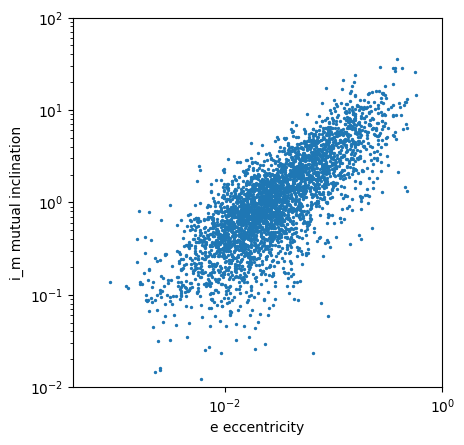

In [13]:
xs, ys = [], []
print(len(eccentricity_inclination))
for x, y in eccentricity_inclination:
    xs.append(x)
    ys.append(y*57.2958)
plt.scatter(xs, ys, s=2)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01, 100)
plt.xlim(0.0004,1)
plt.xlabel('e eccentricity')
plt.xticks(fontsize = 10)
plt.ylabel('i_m mutual inclination')
plt.yticks(fontsize = 10)
ax = plt.gca()
ax.set_box_aspect(1)
plt.show()

## Generate systems at each end of distribution (high and low AMD)

In [15]:
reach = 5 # How many systems you want
amd_min = 0
amd_max = 5*10**(-9)
# For systems to the bottom left of the inclination-eccentricity graph, AMD range should be between 0 and approx 10**(-9).
# For systems to the top right of the inclination-eccentricity graph, AMD range should be between approx 10**(-5) and 1 (or any arbitrarily large value).

eccentricity_inclination_multi = []
Systems = []
count = 0

for trial in tqdm(range(5000)): #arbitrary high number, to reach however many counts required
    if count == reach:
        break
    # Step 2: compute whether the system contains planets using its Gaia Intrinsic Color
    c = 0
    while c < 0.5 or c > 1.7:
        c = np.random.rayleigh(0.81) #not sure if this is allowed
    f_swpa = max(0, min(m*(c-0.81)+f_swpa_med, 1))

    if np.random.uniform(0, 1) > f_swpa:
        clusters = 0
        planets_array = [0]
        continue
    else:
        # Step 3: generate number of clusters in the system, no more than N_c,max
        clusters = ztp(lambda_c, 1)
        while clusters > n_cmax:
            clusters = ztp(lambda_c, 1)

        planets_array = ztp(lambda_p, clusters)
        if clusters == 1:
            # because we want planets_array to be an array, if the output is a single integer, it gets put into an array of length 1
            planets_array = [planets_array]
        for i in range(len(planets_array)):
            # Step 4(a), drawing number of planets in each cluster, no more than N_p,max
            if planets_array[i] > n_pmax:
                planets_array[i] = ztp(lambda_p, 1)

    data = np.zeros((clusters+1, np.max(planets_array)+1, 14))

    data[0, 0, 0] = 1
    data[0, 0, 1] = 1
    data[0, 0, 2] = 3 #$to be calculated$
    data[0, 0, 3] = clusters
    data[0, 0, 4] = np.sum(planets_array)

    for i in range(clusters):
        data[i+1,-1,0] = planets_array[i]

    for i in range(clusters):
        good_cluster = False
        # The while loop exists to account for changes in data if a cluster is discarded, since cluster = cluster - 1
        # The break on the next line checks if we've completed the last cluster, and if so, break out of for loop
        if i + 1 >= len(data):
            break
        while not good_cluster:
            if i + 1 >= len(data):
                break
            i += 1 # This skips the first frame

            #Step 4(b)
            r_p_c = radii()
            while r_p_c < 0.5662: # The mass calculation function from mrexo has radii limits between 0.5661 and 14.421
                r_p_c = radii()
            if data[i, -1, 0] == 1:
                data[i, 0, 0] = r_p_c
            else:
                for j in range(int(data[i, -1, 0])):
                    data[i, j, 0] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))
                    while data[i, j, 0] < max(r_p_min, 0.5662) or data[i, j, 0] > min(r_p_max, 14.42): # These limits come from mrexo mass fitting bounds
                        data[i, j, 0] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))

            #Step 4(c)
            for j in range(int(data[i, -1, 0])):
                if data[0, 0, 1] < 0.072 or data[0, 0, 1] > 0.726: # if out of bounds for 3D fitting
                    data[i, j, 1] = Mdwarf_InferPlMass_FromPlRadius(pl_rade = data[i, j, 0])[0]
                else:
                    data[i, j, 1] = Mdwarf_InferPlMass_FromPlRadiusStMass(pl_rade=data[i, j, 0], st_mass=data[0, 0, 1])[0][0]

            # Step 4(d)
            if data[i, -1, 0] == 1:
                data[i, 0, 2] = 1 #unscaled period
                periods = np.array([1])
                masses = [data[i, 0, 1]]
            else:
                masses = data[i, 0:int(data[i, -1, 0]), 1:2]
                masses = np.concatenate(masses, axis=0)
                periods = unscaled_stab_condition(data[i, -1, 0], masses, data[0, 0, 1])
                if len(periods) == 1 and periods[0] == 0:
                    # Stability condition not met, discard cluster
                    data[0, 0, 3] -= 1
                    data[0, 0, 4] -= data[i, -1, 0]
                    data = np.delete(data, i, 0)
                    i -= 1
                    continue
                else:
                    for j in range(len(periods)):
                        data[i, j, 2] = periods[j]

            # Step 4(e)
            prev_planets_info = []
            for j in range(i):
                for k in range(int(data[j, -1, 0])):
                    prev_planets_info.append([data[j, k, 3], data[j, k, 1]])
            scale_factor = scale_stab_condition(data[i, -1, 0], prev_planets_info, masses, periods, data[0, 0, 1])
            if scale_factor == 0:
                # Stability condition not met, discard cluster
                data[0, 0, 3] -= 1
                data[0, 0, 4] -= data[i, -1, 0]
                data = np.delete(data, i, 0)
                i -= 1
                continue
            else:
                data[i, -1, 1] = scale_factor
                for j in range(int(data[i, -1, 0])):
                    data[i, j, 3] = data[i, j, 2] * scale_factor

            good_cluster = True # This boolean should be flipped to True when everything is good with a cluster and is not discarded, so i increments properly

    if data[0, 0, 4] == 0:
        continue
    elif data[0, 0, 4] == 1:
        data[1, 0, 8] = np.random.rayleigh(sigma_e1) #eccentricity
        data[1, 0, 9] = np.random.uniform(0, 2*np.pi) #pericenter
    else:
        prev_planets_info = []
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                prev_planets_info.append([data[i, j, 3], data[i, j, 1]])
        prev_planets_info.sort(key=lambda x: x[0])

        AMD_tot = calculate_AMD(prev_planets_info, data[0, 0, 1])
        data[0, 0, 2] = AMD_tot
        if data[0, 0, 2] > amd_min and data[0, 0, 2] < amd_max:
            count += 1
            print(f'system added') #helps for viewing progress/frequency at which a good system is found
        else:
            continue

        # Step 6: calculate the total mass of all planets combined
        total_planet_mass = 0
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                total_planet_mass += data[i, j, 1]

        # Step 7: distribute AMD
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                data[i, j, 4] = data[0, 0, 2] * data[i, j, 1] / total_planet_mass

        # Step 8
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                Gamma = computeGamma(data[i, j, 1], data[0, 0, 1], data[i, j, 3])
                total_sum = (data[i, j, 4] / Gamma) * (2 - data[i, j, 4] /Gamma)
                trisect = random_trisect()
                trisect = [x * total_sum for x in trisect]
                data[i, j, 5] = np.sqrt(trisect[0])
                data[i, j, 6] = np.sqrt(trisect[1])
                data[i, j, 7] = np.sqrt(trisect[2])
                data[i, j, 8] = np.sqrt(trisect[0] + trisect[1])
                data[i, j, 9] = np.arctan(np.sqrt(trisect[0] / trisect[1]))
                data[i, j, 10] = np.arcsin(np.sqrt(trisect[2]))

        # Step 9
        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                data[i, j, 11] = np.random.uniform(0, 2*np.pi)
                data[i, j, 12] = np.random.uniform(0, 2*np.pi)

        for i in range(len(data)):
            if i == 0:
                continue
            for j in range(int(data[i, -1, 0])):
                eccentricity_inclination_multi.append([data[i, j, 8], data[i, j, 10]])

        Systems.append(data)

  0%|          | 12/5000 [00:07<36:25,  2.28it/s]

system added


  4%|▍         | 210/5000 [01:28<46:25,  1.72it/s]

system added


 13%|█▎        | 650/5000 [04:26<38:01,  1.91it/s]

system added


 14%|█▎        | 678/5000 [04:38<31:23,  2.29it/s]

system added


 14%|█▍        | 721/5000 [04:54<29:09,  2.45it/s]

system added


28


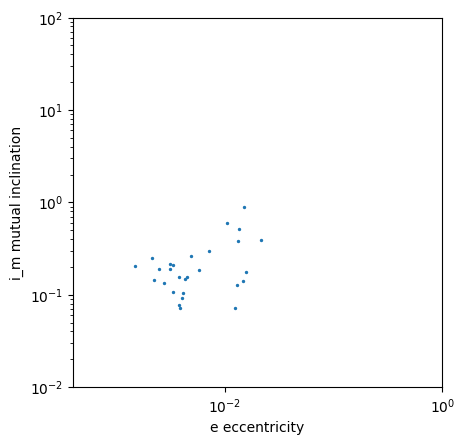

In [16]:
# view the inc/ecc of planets in the selected systems
xs, ys = [], []
print(len(eccentricity_inclination_multi))
for x, y in eccentricity_inclination_multi:
    xs.append(x)
    ys.append(y*57.2958) # radian-degree conversion
plt.scatter(xs, ys, s=2)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01, 100)
plt.xlim(0.0004,1)
plt.xlabel('e eccentricity')
plt.xticks(fontsize = 10)
plt.ylabel('i_m mutual inclination')
plt.yticks(fontsize = 10)
ax = plt.gca()
ax.set_box_aspect(1)
plt.show()

4


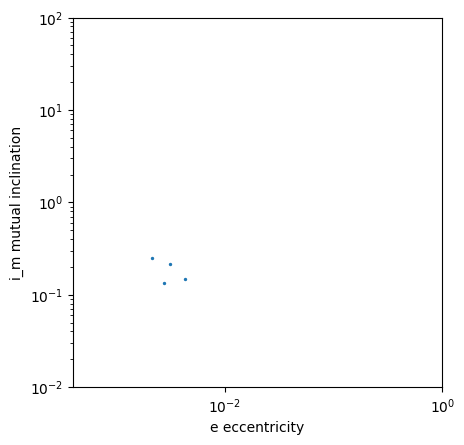

In [17]:
# view the inc/ecc of planets in one particular system

view_system = []
for i in range(len(Systems[0])): # Change the array index to select a system
    for j in range(int(data[i, -1, 0])):
        view_system.append([data[i, j, 8], data[i, j, 10]])
xxs, yys = [], []
print(len(view_system))
for x, y in view_system:
    xxs.append(x)
    yys.append(y*57.2958) # radian-degree conversion
plt.scatter(xxs, yys, s=2)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01, 100)
plt.xlim(0.0004,1)
plt.xlabel('e eccentricity')
plt.xticks(fontsize = 10)
plt.ylabel('i_m mutual inclination')
plt.yticks(fontsize = 10)
ax = plt.gca()
ax.set_box_aspect(1)
plt.show()

In [18]:
print(Systems) # See data for all selected systems

[array([[[1.00000000e+00, 1.00000000e+00, 3.53282835e-09, 3.00000000e+00,
         6.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+0